<a href="https://colab.research.google.com/github/nataliasc/dyadicdecisionmaking/blob/2ifc-random-dots/dataanalysis/compact_fitHDDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Estimate DDM parameters using HDDM **

adapted from Anne Urai's fitHDDM.py script https://github.com/anne-urai/2019_Urai_choice-history-ddm/blob/master/fitHDDM.py

# Set up section

In [1]:
!apt-get install python3.5

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpython3.5-minimal libpython3.5-stdlib python3.5-minimal
Suggested packages:
  python3.5-venv python3.5-doc binfmt-support
The following NEW packages will be installed:
  libpython3.5-minimal libpython3.5-stdlib python3.5 python3.5-minimal
0 upgraded, 4 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,135 kB of archives.
After this operation, 22.7 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 libpython3.5-minimal amd64 3.5.10-1+bionic2 [542 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 python3.5-minimal amd64 3.5.10-1+bionic2 [1,273 kB]
Get:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 libpython3.5-stdlib amd64 3.5.10-1+bionic2 [2,107 kB]
Get:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd

In [2]:
!pip install pymc

     |████████████████████████████████| 385 kB 5.0 MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp37-cp37m-linux_x86_64.whl size=1353156 sha256=598b522d2f6ce08b25d93de76183a88e5a0c8ff045bf29a0ba2ff1f2e0e27005
  Stored in directory: /root/.cache/pip/wheels/3b/9b/1d/2a2ddbe80519db2698745f0988ce50c36ad38aac886a4ee0ca
Successfully built pymc


In [3]:
!pip install pandas patsy

In [4]:
!pip install kabuki

     |████████████████████████████████| 44 kB 1.6 MB/s 
  Created wheel for kabuki: filename=kabuki-0.6.3-py3-none-any.whl size=36545 sha256=3d4ca72fdbe997133d6432c66cf227e4cb5cd8afef31bf677570f57640bee653
  Stored in directory: /root/.cache/pip/wheels/29/cb/6a/02f80c7cde0e973c5ec0f4202aee3ab1b10d84682052d99af5
Successfully built kabuki


In [5]:
!pip install hddm

     |████████████████████████████████| 601 kB 5.2 MB/s 
  Created wheel for hddm: filename=HDDM-0.8.0-cp37-cp37m-linux_x86_64.whl size=556571 sha256=ec0688e7c60eb94804c428a5b336bd45ea3014d6cb4c1af2efb0855171bf0147
  Stored in directory: /root/.cache/pip/wheels/13/13/8b/4fb929469ddb2844cc33d7e3331aaae7668152b496f4fab402
Successfully built hddm


In [6]:
import glob
import hddm
import kabuki
import numpy as np
import os
import pandas as pd
import time

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [7]:
print(hddm.__version__)

0.8.0


# Helper functions

In [8]:
def recode_4stimcoding(mydata):
    #code stimulus and response direction left as 0, leave direction right as 1.
    
    mydata.loc[mydata['direction']==-1,'direction'] = 0
    mydata.loc[mydata['response']==-1,'response'] = 0
    for col in mydata.columns.tolist():
        if ('stim' in col) or ('resp' in col):
            mydata.loc[mydata[col]==-1,col] = 0
    
    return mydata

def z_link_func(x):
    return 1 / (1 + np.exp(-(x.values.ravel())))

def aic(self):
    k = len(self.get_stochastics())
    logp = sum([x.logp for x in self.get_observeds()['node']])
    return 2 * k - 2 * logp


def bic(self):
    k = len(self.get_stochastics())
    n = len(self.data)
    logp = sum([x.logp for x in self.get_observeds()['node']])
    return -2 * logp + k * np.log(n)



In [18]:
def make_model(mydata, model_name, trace_id, nlag=0):
    
    #check once more for consistency of parameters before model is created
    if "nohist" not in model_name and nlag == 0:
        print("For all models with history effects, 'nlag' must be non-zero")
        exit(0)
    elif "nohist" in model_name and nlag != 0:
        print("'nlag' specified but model is without history effect. 'nlag' value is ignored\n")
        nlag = 0
         

    if nlag != 0:
      col_resp = 'l' + str(nlag) + '_resp'
      col_stim = 'l' + str(nlag) + '_stim'
      col_subject = 'l' + str(nlag) + '_subject'
      col_repeat = 'l' + str(nlag) + '_repeat'
             
    if model_name == 'stimcoding_nohist': # NO HISTORY FOR MODEL COMPARISON
        m = hddm.HDDMStimCoding(mydata, stim_col='direction', split_param='v',
                drift_criterion=True, bias=True, p_outlier=0.05,
                include=('sv', 'sz'), group_only_nodes=['sv', 'sz'])
    elif model_name == 'stimcoding_dc_resp':
        m = hddm.HDDMStimCoding(mydata, stim_col='direction', split_param='v',
                drift_criterion=True, bias=True, p_outlier=0.05,
                include=('sv', 'sz'), group_only_nodes=['sv', 'sz'],
                depends_on={'dc':[col_resp]})
    elif model_name == 'stimcoding_z_resp':
        m = hddm.HDDMStimCoding(mydata, stim_col='direction', split_param='v',
                drift_criterion=True, bias=True, p_outlier=0.05,
                include=('sv', 'sz'), group_only_nodes=['sv', 'sz'],
                depends_on={'z':[col_resp]})
    elif model_name == 'stimcoding_dc_z_resp':
        m = hddm.HDDMStimCoding(mydata, stim_col='direction', split_param='v',
                drift_criterion=True, bias=True, p_outlier=0.05,
                include=('sv', 'sz'), group_only_nodes=['sv', 'sz'],
                depends_on={'dc':[col_resp], 'z':[col_resp]})
    elif model_name == 'stimcoding_dc_z_st_resp': # also estimate across-trial variability in nondecision time
        m = hddm.HDDMStimCoding(mydata, stim_col='direction', split_param='v',
                drift_criterion=True, bias=True, p_outlier=0.05,
                include=('sv', 'sz', 'st'), group_only_nodes=['sv', 'sz', 'st'],
                depends_on={'dc':[col_resp], 'z':[col_resp]})
    # ============================================ #
    # Dyadic models..depends on whether the lagged trial was own for partner's
    # ============================================ #
    elif model_name == 'stimcoding_dc_z_resp_dyadic':
        m = hddm.HDDMStimCoding(mydata, stim_col='direction', split_param='v',
                drift_criterion=True, bias=True, p_outlier=0.05,
                include=('sv', 'sz'), group_only_nodes=['sv', 'sz'],
                depends_on={'dc':[col_resp, col_subject], 'z':[col_resp, col_subject]})
    
    return m

In [10]:
def get_full_model_name(m,lag):
    return m if 'nohist' in m else m + '_l' + str(lag)

In [11]:
def run_model(m, mypath, model_name, trace_id, n_samples):
    print("Running {:<s}, trace_id {:2d}".format(model_name,trace_id))
    print("finding starting values")
    try:
        m.find_starting_values() # this should help the sampling
    except Exception as e:
        print(e) #even if starting values couldnt be found, sampling can continue

    print("begin sampling")
    #m.sample(n_samples, burn=n_samples/2, thin=3)
    
    m.sample(n_samples, burn=n_samples/2, thin=3, db='pickle',
        dbname=os.path.join(mypath, model_name, 'modelfit-md%d.db'%trace_id))
    m.save(os.path.join(mypath, model_name, 'modelfit-md%d.model'%trace_id)) # save the model to disk
    
    # ============================================ #
    # save the output values
    # ============================================ #

    # save the DIC for this model
    text_file = open(os.path.join(mypath, model_name, 'DIC-md%d.txt'%trace_id), 'w')
    text_file.write("Model {}: {}\n".format(trace_id, m.dic))
    text_file.close()

    # save the other model comparison indices
    df = dict()
    df['trace_id'] = trace_id
    df['dic_original'] = [m.dic]
    df['aic'] = [aic(m)]
    df['bic'] = [bic(m)]
    df2 = pd.DataFrame(df)
    df2.to_csv(os.path.join(mypath, model_name, 'model_comparison_md%d.csv'%trace_id),index=False)


# Prep before running HDDM

In [12]:
models_collection = {
    1: 'stimcoding_nohist',  # no history baseline model
    2: 'stimcoding_dc_resp',  #previous response dependent, nlags needed
    3: 'stimcoding_z_resp',  #previous response dependent, nlags needed
    4: 'stimcoding_dc_z_resp', #previous response dependent, nlags needed
    5: 'stimcoding_dc_z_st_resp',  #previous response dependent, nlags needed
    6: 'stimcoding_dc_z_resp_dyadic' #previous response dependent, nlags needed, dyadic assessment
}


In [13]:
"""
Prepare for running: Part I
Select model and the nth prev trial intended to be analyzed
"""
model = models_collection[6]
lag = 1
chains = 2
#trace_ids = range(1,chains+1)
trace_ids = [2]
n_samples = 5000

mypath = "drive/MyDrive/DDM_SP_2021-22/data/output"
full_model_name = get_full_model_name(model,lag)
thispath = os.path.join(mypath,full_model_name)
if not os.path.exists(thispath):
    os.makedirs(thispath)


In [14]:
"""
Prepare for running:Part II
Setup the folders and fetch data
"""
datasrc = "drive/MyDrive/DDM_SP_2021-22/data/coded"
datafile = "all_trials_data.csv"

#if the concatenated data from each experimnetal run exists, use that, else create the concatenated data first
data_loc = os.path.join(datasrc,datafile)
if os.path.exists(data_loc):
    mydata = hddm.load_csv(data_loc)
    print("Concatenated datafile with full experiment data found and loaded")
else:
    files = glob.glob(os.path.join(datasrc,'pair*.csv'))
    mydata = pd.concat([pd.read_csv(f) for f in files ])
    mydata.to_csv(data_loc,index=False,header=True)
    print("Concatenated datafile with full experiment data created")


Concatenated datafile with full experiment data found and loaded


**Data preparation for HDDMStimCoding**

In [15]:
#remove columns not needed
col_prefix = 'l' + str(lag) + '_'
cols_to_drop = [x for x in mydata.columns if (x[0] == 'l') and (not col_prefix in x)]
cols_to_drop.extend(['correct','block','trial',col_prefix + 'repeat'])
mydata.drop(columns=cols_to_drop,axis=1,inplace=True)

#recode the subject in lagged trial..own:1, partner:0
mask = mydata[col_prefix + 'subject'] == mydata['subj_idx']
mydata.loc[mask,col_prefix + 'subject'] = 'own'
mydata.loc[~mask,col_prefix + 'subject'] = 'partner'

#Coding for response column. Use stimulus-coding: 1: right, 0:left
mydata.loc[mydata['response'] == -1,'response'] = 0
mydata.loc[mydata[col_prefix + 'resp'] == -1,col_prefix + 'resp'] = 0

"""
HDDMStimCoding: Add a column to your data that codes which stimulus was correct.
For identifier 1, drift-rate v will be used while for identifier 0, -v will be used.
"""
#Coding for direction column. 1:right,0:left
mydata.loc[mydata['direction'] == -1,'direction'] = 0
mydata.loc[mydata[col_prefix + 'stim'] == -1,col_prefix + 'stim'] = 0

if 'nohist' not in model:
  mydata = mydata.dropna().reset_index(drop=True)


In [16]:
mydata

,direction,response,rt,subj_idx,l1_stim,l1_resp,l1_subject,l1_rt
0,1,0,0.701318,268006_2,0.0,0.0,own,0.982014
1,1,1,0.875515,268006_2,1.0,0.0,own,0.701318
2,1,1,0.883835,268006_2,1.0,1.0,own,0.875515
3,1,1,1.138592,268006_2,1.0,1.0,own,0.883835
4,1,1,0.984143,268006_1,1.0,1.0,partner,1.138592
...,...,...,...,...,...,...,...,...
9458,0,0,0.650772,958733_2,0.0,0.0,partner,0.566219
9459,0,1,0.848053,958733_2,0.0,0.0,own,0.650772
9460,0,1,0.706652,958733_1,0.0,1.0,partner,0.848053
9461,1,1,1.768333,958733_1,0.0,1.0,own,0.706652


#DDM param estimations are done for 3 conditions: 

1. No history condition

2. depends on the lagged trial response 

3. depends on the lagged trial response and own (code 1) or partner (code 0)trial


In [ ]:
# ============================================ #
# Main HDDM parameter estimation
# ============================================ #
starttime = time.time()
for trace_id in trace_ids:
    model_filename = os.path.join(mypath, full_model_name, 'modelfit-md%d.model' % trace_id)
    m = make_model(mydata, model, trace_id, lag)
    run_model(m, mypath, full_model_name, trace_id, n_samples)
    elapsed = time.time() - starttime
    print("\nElapsed time for %s, trace_id %d, %d samples: %f seconds\n" % (model, trace_id, n_samples, elapsed))



Running stimcoding_dc_z_resp_dyadic_l1, trace_id  2
finding starting values


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


begin sampling
 [-----------------100%-----------------] 5001 of 5000 complete in 8246.3 sec
Elapsed time for stimcoding_dc_z_resp_dyadic, trace_id 2, 5000 samples: 8287.036316 seconds



#Check the model and convergence

In [ ]:
#load all models
allmodels = []
print("Combining all traces for %s" % full_model_name)
modelfiles = glob.glob(os.path.join(mypath, full_model_name, 'modelfit-md*.model'))
for m in modelfiles:
  try:
    allmodels.append(hddm.load(m))
  except Exception as e:
    print("Couldnt load fitted model {}\n".format(m))
    print(e)
    exit(0)

print("{} traces found and loaded".format(len(modelfiles)))

#GM convergence check
# Values should be close to 1 and not larger than 1.02 
print("\n#####GELMAN RUBIN TEST OUTPUT#####")
try:
  gr = hddm.analyze.gelman_rubin(allmodels)
  with open(os.path.join(mypath, full_model_name, 'gelman_rubin.txt'), 'w') as text_file:        
    for p in gr.items():
      msg = "Non-convergence" if abs(p[1] - 1) > 0.02 else "OK"
      print("{:<24s} {:6.5f} {}".format(p[0],p[1],msg))
      text_file.write("{:<24s} {:6.5f} {}\n".format(p[0],p[1],msg))
except Exception as e:
  print("Error: {}".format(e))

Combining all traces for stimcoding_dc_z_resp_dyadic_l1
2 traces found and loaded

#####GELMAN RUBIN TEST OUTPUT#####
a                        0.99941 OK
a_std                    0.99940 OK
a_subj.268006_1          1.00018 OK
a_subj.268006_2          1.00030 OK
a_subj.280933_1          1.00025 OK
a_subj.280933_2          0.99963 OK
a_subj.476030_1          0.99940 OK
a_subj.476030_2          1.00098 OK
a_subj.659640_1          1.00022 OK
a_subj.659640_2          0.99978 OK
a_subj.725232_1          1.00063 OK
a_subj.725232_2          0.99942 OK
a_subj.754128_1          1.00672 OK
a_subj.754128_2          0.99968 OK
a_subj.812810_1          1.00081 OK
a_subj.812810_2          0.99955 OK
a_subj.897304_1          0.99983 OK
a_subj.897304_2          1.00172 OK
a_subj.900778_1          1.00182 OK
a_subj.900778_2          0.99962 OK
a_subj.958733_1          1.00410 OK
a_subj.958733_2          0.99946 OK
v                        1.00035 OK
v_std                    0.99943 OK
v_subj.268006_1   

In [ ]:
#concat all traces into one model
m = kabuki.utils.concat_models(allmodels)

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting sv
Plotting sz
Plotting z(0.0.own)
Plotting z(0.0.partner)
Plotting z(1.0.own)
Plotting z(1.0.partner)
Plotting z_std
Plotting dc(0.0.own)
Plotting dc(0.0.partner)
Plotting dc(1.0.own)
Plotting dc(1.0.partner)
Plotting dc_std


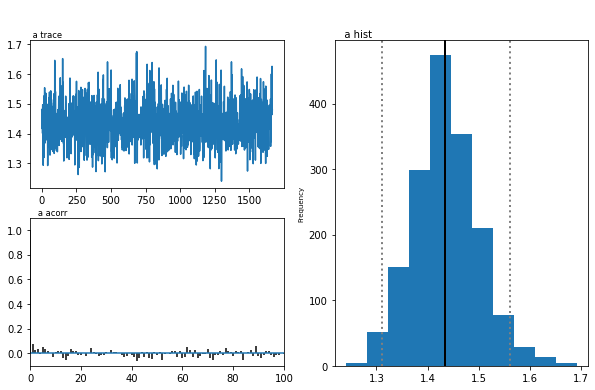

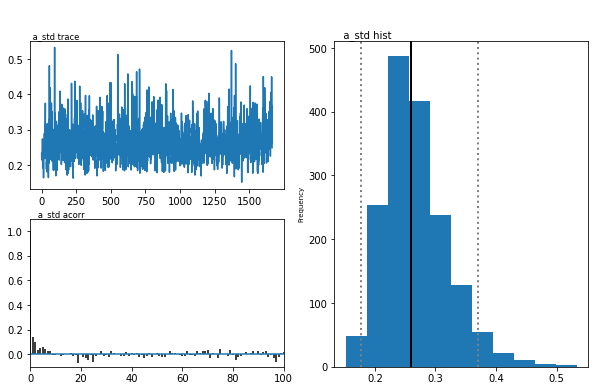

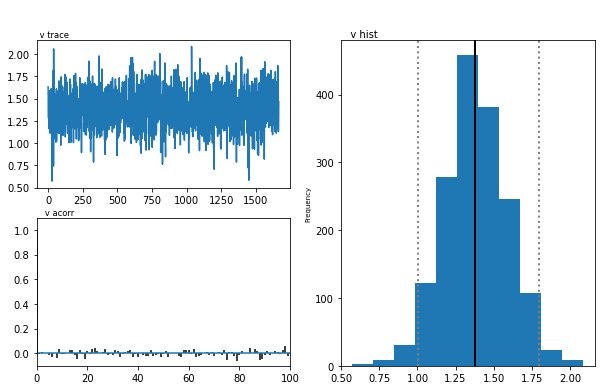

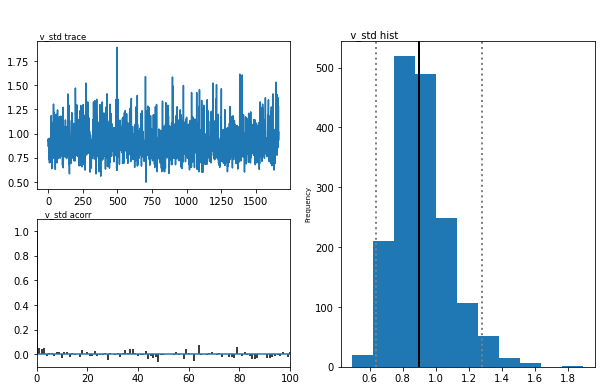

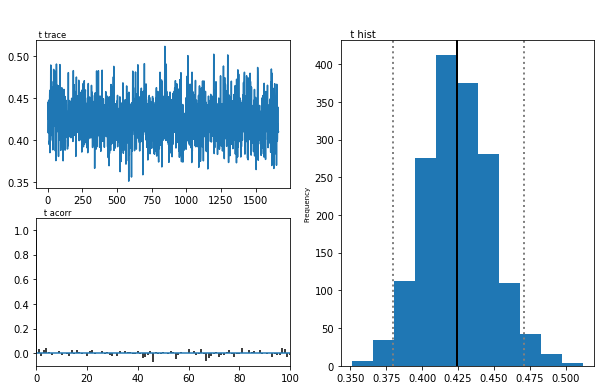

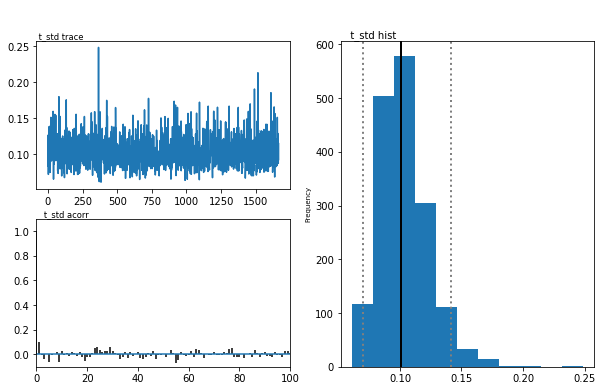

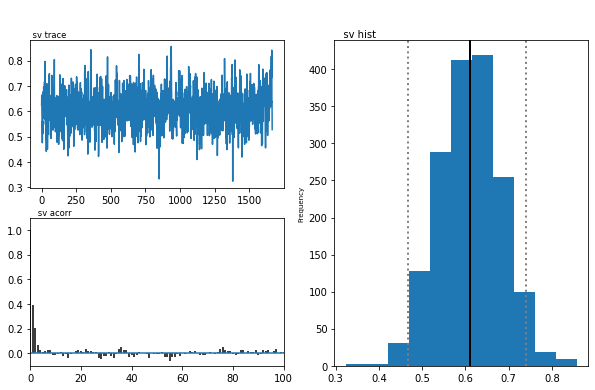

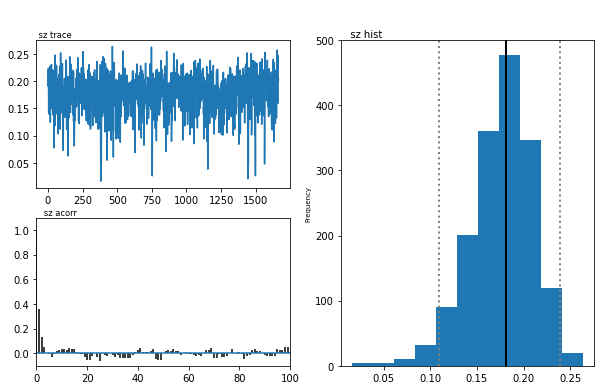

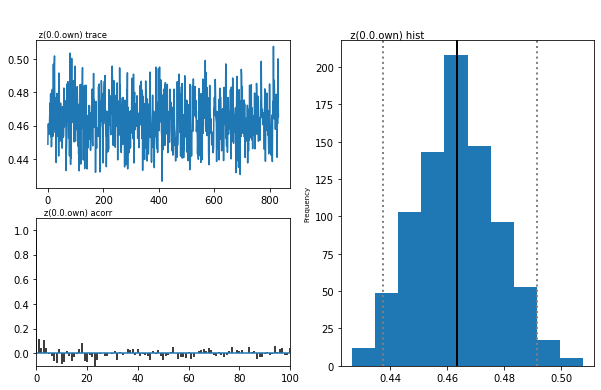

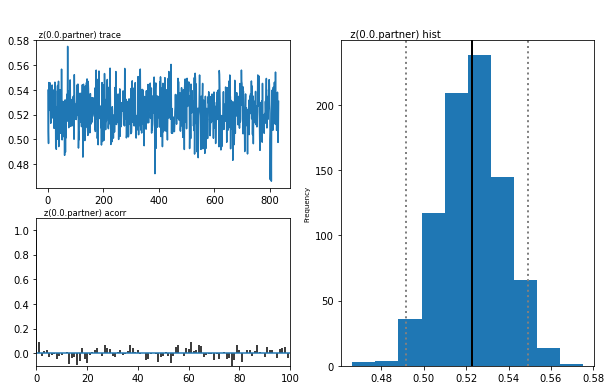

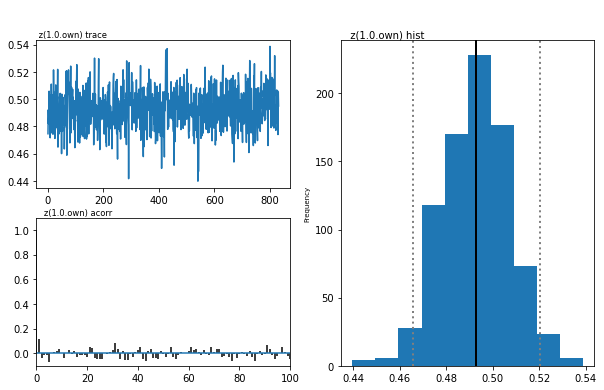

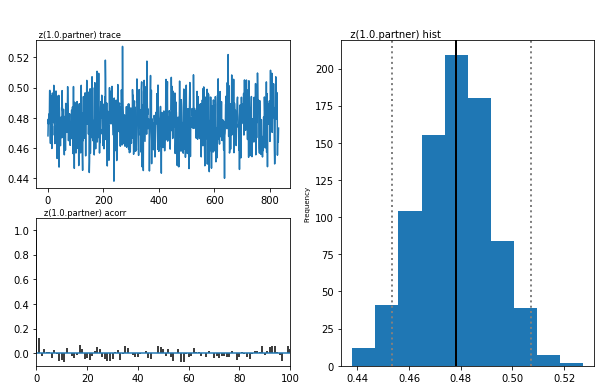

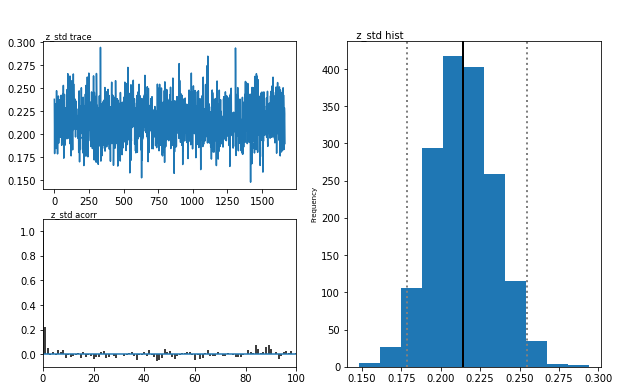

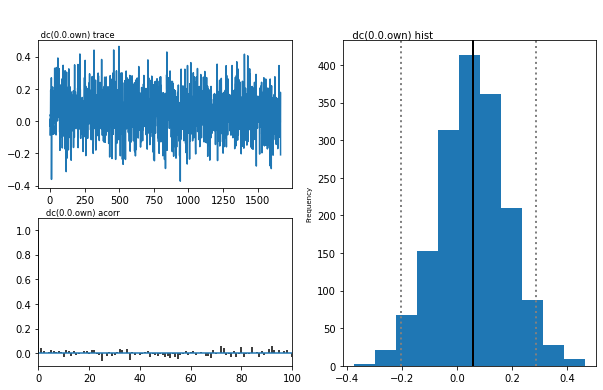

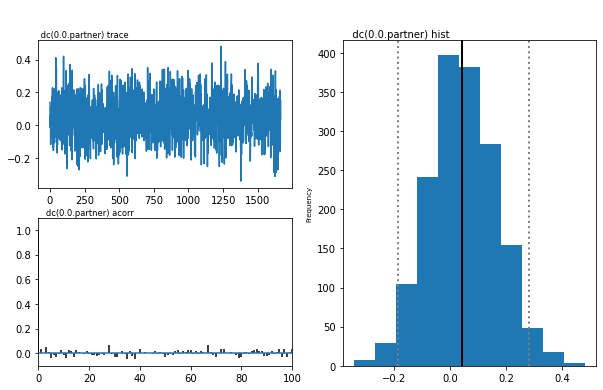

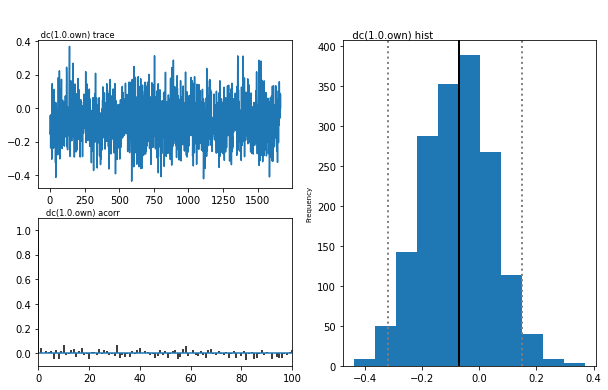

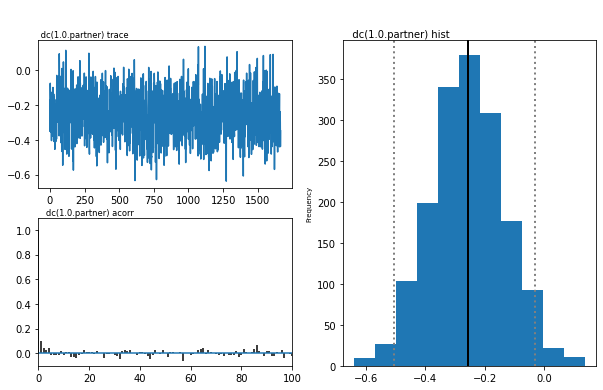

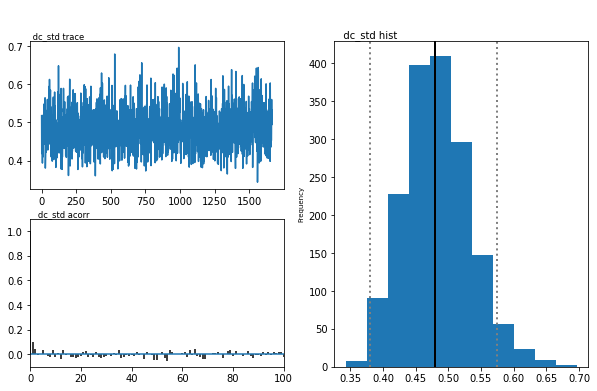

In [ ]:
#Visually check the model
m.plot_posteriors()

In [ ]:
"""
If all goes well in previous step then...
"""
#save combined model
m.save(os.path.join(mypath, full_model_name, 'modelfit-combined.model'))  # save combined modelto disk
# SAVE POINT ESTIMATES
print("saving stats...")
results = m.gen_stats()  # point estimate for each parameter and subject
results.to_csv(os.path.join(mypath, full_model_name, 'results-combined.csv'))
# save the DIC for this model
text_file = open(os.path.join(mypath, full_model_name, 'DIC-combined.txt'), 'w')
text_file.write("Combined model: {}\n".format(m.dic))
text_file.close()
print('done')
# SAVE TRACES
print("saving traces...")
# get the names for all nodes that are available here
group_traces = m.get_group_traces()
group_traces.to_csv(os.path.join(mypath, full_model_name, 'group_traces.csv'))
all_traces = m.get_traces()
all_traces.to_csv(os.path.join(mypath, full_model_name, 'all_traces.csv'))
print('done')
# CONCATENATE MODEL COMPARISON
# average model comparison values across chains
print('concatenating model comparison...')
fls = glob.glob(os.path.join(mypath, full_model_name, 'model_comparison_md*.csv'))
tmpdf = pd.concat([pd.read_csv(f) for f in fls ])
# average over chains
df2 = tmpdf.describe().loc[['mean']]
df2.to_csv(os.path.join(mypath, full_model_name, 'model_comparison.csv')) # save comparison to disk
print('done')

saving stats...
done
saving traces...
done
concatenating model comparison...
done


# POSTERIOR PREDICTIVES TO ASSESS MODEL FIT

In [ ]:
starttime = time.time()
print("computing ppc")
# specify how many samples are needed
m = hddm.load(os.path.join(mypath,full_model_name, 'modelfit-combined.model'))
nsmp = 500
ppc = hddm.utils.post_pred_gen(m, append_data=True, samples=nsmp)
# save as pandas dataframe
ppc.to_csv(os.path.join(mypath, full_model_name, 'ppc_data.csv'), index=True)
elapsed = time.time() - starttime
print( "\nElapsed time for %s, PPC: %f seconds\n" %(full_model_name,elapsed))

computing ppc
 [-----------------101%-----------------] 163 of 160 complete in 9692.5 sec
Elapsed time for stimcoding_dc_z_resp_dyadic_l1, PPC: 9759.824101 seconds



In [ ]:
ppc_compare = hddm.utils.post_pred_stats(mydata, ppc)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
ppc_compare

,observed,mean,std,SEM,MSE,credible,quantile,mahalanobis
stat,,,,,,,,
accuracy,0.491070,0.493304,0.316941,0.000005,0.100459,True,50.000000,0.007047
mean_ub,0.789970,0.813578,0.198829,0.000557,0.040094,True,47.770702,0.118736
std_ub,0.299250,0.220385,0.102160,0.006220,0.016655,True,82.802551,0.771980
10q_ub,0.467278,0.590701,0.170524,0.015233,0.044325,True,21.656052,0.723783
30q_ub,0.606650,0.692173,0.186094,0.007314,0.041934,True,31.210192,0.459570
50q_ub,0.732838,0.779662,0.204872,0.002193,0.044159,True,43.949043,0.228554
70q_ub,0.900047,0.885953,0.231555,0.000199,0.053811,True,52.866241,0.060867
90q_ub,1.177190,1.066877,0.269458,0.012169,0.084747,True,66.878983,0.409386
mean_lb,-0.758232,-0.793217,0.201875,0.001224,0.041977,True,55.000000,0.173297


In [ ]:
ppc_compare.to_csv(os.path.join(mypath, full_model_name, 'ppc_compare.csv'), index=False,header=True)

code in cell below is for debugging purposes only

In [ ]:

import pymc as pm
import numpy as np
import pymc.progressbar as pbar

def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]

def _post_pred_generate(bottom_node, samples=500, data=None, append_data=True):
    """Generate posterior predictive data from a single observed node."""
    datasets = []
    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        if append_data and data is not None:
            sampled_data.reset_index(inplace=True)  # Only modification of original Kabuki code
            sampled_data = sampled_data.join(data.reset_index(), lsuffix='_sampled')
        datasets.append(sampled_data)
    return datasets

def pst_pred_gen(model, groupby=None, samples=500, append_data=False, progress_bar=True):
    results = {}

    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        iter_data = ((name, model.data.iloc[obs['node'].value.index]) for name, obs in model.iter_observeds())
    else:
        iter_data = model.data.groupby(groupby)


    for name, data in iter_data:
        print(name)
        print(data['subj_idx'])
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, 'random'):
            continue # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(node, samples=samples, data=data, append_data=append_data)
        results[name] = pd.concat(datasets, names=['sample'], keys=list(range(len(datasets))))

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    return pd.concat(results, names=['node'])
nsmp = 50
testm = hddm.load(os.path.join(mypath,full_model_name, 'modelfit-md2.model'))
ppc = pst_pred_gen(testm, append_data=True, samples=nsmp)


wfpt(0.0.0.own).268006_1
14     268006_1
24     268006_1
72     268006_1
134    268006_1
157    268006_1
169    268006_1
201    268006_1
216    268006_1
229    268006_1
239    268006_1
274    268006_1
280    268006_1
328    268006_1
344    268006_1
377    268006_1
387    268006_1
404    268006_1
440    268006_1
520    268006_1
521    268006_1
522    268006_1
563    268006_1
564    268006_1
582    268006_1
588    268006_1
603    268006_1
608    268006_1
609    268006_1
614    268006_1
615    268006_1
616    268006_1
627    268006_1
651    268006_1
662    268006_1
709    268006_1
710    268006_1
713    268006_1
715    268006_1
716    268006_1
744    268006_1
745    268006_1
748    268006_1
Name: subj_idx, dtype: object
wfpt(0.0.0.own).268006_2
11     268006_2
12     268006_2
20     268006_2
30     268006_2
49     268006_2
50     268006_2
65     268006_2
84     268006_2
85     268006_2
86     268006_2
117    268006_2
120    268006_2
174    268006_2
197    268006_2
205    268006_2
209    2

KeyboardInterrupt: ignored

# QUANTILE OPTIMISATION

In [17]:
# http://ski.clps.brown.edu/hddm_docs/howto.html#run-quantile-opimization
subj_params = []
bic_temp = []

for subj_idx, subj_data in mydata.groupby('subj_idx'):
    m_subj = make_model(subj_data, model, 1,lag)
    thismodel = m_subj.optimize('gsquare', quantiles=[0.1, 0.3, 0.5, 0.7, 0.9], n_runs=5)
    thismodel.update({'subj_idx':subj_idx}) # keep original subject number
    subj_params.append(thismodel)
    bic_temp.append(m_subj.bic_info)

params = pd.DataFrame(subj_params)
params.to_csv(os.path.join(mypath, full_model_name, 'Gsquare.csv'))
pd.DataFrame(bic_temp).to_csv(os.path.join(mypath, full_model_name, 'BIC.csv'))
print("QUANTILE OPTIMISATION. DONE!!!")

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 1921.477233
         Iterations: 15
         Function evaluations: 2272
Optimization terminated successfully.
         Current function value: 1921.636409
         Iterations: 13
         Function evaluations: 1974
Optimization terminated successfully.
         Current function value: 1921.499536
         Iterations: 15
         Function evaluations: 2282
Optimization terminated successfully.
         Current function value: 1921.545929
         Iterations: 13
         Function evaluations: 2061
Optimization terminated successfully.
         Current function value: 1921.926980
         Iterations: 10
         Function evaluations: 1527


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 1987.056852
         Iterations: 15
         Function evaluations: 2367
Optimization terminated successfully.
         Current function value: 1986.940812
         Iterations: 7
         Function evaluations: 1224
Optimization terminated successfully.
         Current function value: 1987.106711
         Iterations: 16
         Function evaluations: 2698
Optimization terminated successfully.
         Current function value: 1987.085652
         Iterations: 10
         Function evaluations: 1579
Optimization terminated successfully.
         Current function value: 1987.218246
         Iterations: 14
         Function evaluations: 2146


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 2456.867888
         Iterations: 11
         Function evaluations: 2848


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2446.802767
         Iterations: 10
         Function evaluations: 1566
Optimization terminated successfully.
         Current function value: 2456.356607
         Iterations: 10
         Function evaluations: 2076
Optimization terminated successfully.
         Current function value: 2458.369504
         Iterations: 13
         Function evaluations: 3055
Optimization terminated successfully.
         Current function value: 2456.456786
         Iterations: 9
         Function evaluations: 1834


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 2327.748473
         Iterations: 11
         Function evaluations: 2266
Optimization terminated successfully.
         Current function value: 2276.423825
         Iterations: 7
         Function evaluations: 1134


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2277.593552
         Iterations: 8
         Function evaluations: 1210
Optimization terminated successfully.
         Current function value: 2278.931946
         Iterations: 9
         Function evaluations: 1409
Optimization terminated successfully.
         Current function value: 2273.191322
         Iterations: 15
         Function evaluations: 2556


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 2434.849372
         Iterations: 11
         Function evaluations: 1882
Optimization terminated successfully.
         Current function value: 2435.759667
         Iterations: 9
         Function evaluations: 1431
Optimization terminated successfully.
         Current function value: 2434.719203
         Iterations: 10
         Function evaluations: 1708
Optimization terminated successfully.
         Current function value: 2399.323992
         Iterations: 11
         Function evaluations: 1742
Optimization terminated successfully.
         Current function value: 2435.117449
         Iterations: 9
         Function evaluations: 1721


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 2159.433467
         Iterations: 18
         Function evaluations: 2958


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2159.000726
         Iterations: 8
         Function evaluations: 1245
Optimization terminated successfully.
         Current function value: 2159.339828
         Iterations: 12
         Function evaluations: 1890
Optimization terminated successfully.
         Current function value: 2195.709526
         Iterations: 7
         Function evaluations: 1204
Optimization terminated successfully.
         Current function value: 2159.364814
         Iterations: 9
         Function evaluations: 1412


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2330.622335
         Iterations: 17
         Function evaluations: 2784
Optimization terminated successfully.
         Current function value: 2336.281199
         Iterations: 9
         Function evaluations: 1392
Optimization terminated successfully.
         Current function value: 2330.641393
         Iterations: 17
         Function evaluations: 2801
Optimization terminated successfully.
         Current function value: 2330.361551
         Iterations: 12
         Function evaluations: 2034
Optimization terminated successfully.
         Current function value: 2332.051475
         Iterations: 7
         Function evaluations: 1131


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2287.525035
         Iterations: 10
         Function evaluations: 1521
Optimization terminated successfully.
         Current function value: 2286.834371
         Iterations: 11
         Function evaluations: 1753
Optimization terminated successfully.
         Current function value: 2287.463091
         Iterations: 10
         Function evaluations: 1496
Optimization terminated successfully.
         Current function value: 2287.510822
         Iterations: 7
         Function evaluations: 1050
Optimization terminated successfully.
         Current function value: 2287.506575
         Iterations: 9
         Function evaluations: 1321


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 1724.443300
         Iterations: 10
         Function evaluations: 1822
Optimization terminated successfully.
         Current function value: 1724.072430
         Iterations: 11
         Function evaluations: 2118


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 1725.838591
         Iterations: 6
         Function evaluations: 924
Optimization terminated successfully.
         Current function value: 1724.981065
         Iterations: 9
         Function evaluations: 1530


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


Optimization terminated successfully.
         Current function value: 1724.651612
         Iterations: 8
         Function evaluations: 1241


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 1873.426213
         Iterations: 7
         Function evaluations: 1171
Optimization terminated successfully.
         Current function value: 1872.991176
         Iterations: 8
         Function evaluations: 1381
Optimization terminated successfully.
         Current function value: 1873.018419
         Iterations: 9
         Function evaluations: 1753
Optimization terminated successfully.
         Current function value: 1892.697627
         Iterations: 9
         Function evaluations: 1366


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 1892.157756
         Iterations: 9
         Function evaluations: 1389


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2082.250457
         Iterations: 10
         Function evaluations: 1674
Optimization terminated successfully.
         Current function value: 2132.638537
         Iterations: 6
         Function evaluations: 1122
Optimization terminated successfully.
         Current function value: 2095.848799
         Iterations: 7
         Function evaluations: 1267
Optimization terminated successfully.
         Current function value: 7165.271853
         Iterations: 2
         Function evaluations: 356
Optimization terminated successfully.
         Current function value: 2083.968751
         Iterations: 7
         Function evaluations: 1189


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2410.747088
         Iterations: 16
         Function evaluations: 2486
Optimization terminated successfully.
         Current function value: 2410.283986
         Iterations: 13
         Function evaluations: 1984
Optimization terminated successfully.
         Current function value: 7046.669371
         Iterations: 3
         Function evaluations: 427
Optimization terminated successfully.
         Current function value: 2410.907912
         Iterations: 18
         Function evaluations: 2906
Optimization terminated successfully.
         Current function value: 2411.555081
         Iterations: 12
         Function evaluations: 1971


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2162.196515
         Iterations: 9
         Function evaluations: 1373
Optimization terminated successfully.
         Current function value: 2161.577412
         Iterations: 9
         Function evaluations: 1395
Optimization terminated successfully.
         Current function value: 2162.463463
         Iterations: 9
         Function evaluations: 1371
Optimization terminated successfully.
         Current function value: 2161.393177
         Iterations: 8
         Function evaluations: 1217
Optimization terminated successfully.
         Current function value: 2160.008176
         Iterations: 5
         Function evaluations: 747


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 2273.612662
         Iterations: 13
         Function evaluations: 1947


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2273.349831
         Iterations: 14
         Function evaluations: 2175
Optimization terminated successfully.
         Current function value: 2273.450841
         Iterations: 13
         Function evaluations: 1959
Optimization terminated successfully.
         Current function value: 2275.139858
         Iterations: 10
         Function evaluations: 1572
Optimization terminated successfully.
         Current function value: 2273.297134
         Iterations: 12
         Function evaluations: 1836


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2126.563091
         Iterations: 7
         Function evaluations: 1046
Optimization terminated successfully.
         Current function value: 2126.387484
         Iterations: 6
         Function evaluations: 889
Optimization terminated successfully.
         Current function value: 6968.003315
         Iterations: 2
         Function evaluations: 320
Optimization terminated successfully.
         Current function value: 2127.118443
         Iterations: 7
         Function evaluations: 1047
Optimization terminated successfully.
         Current function value: 2126.921789
         Iterations: 8
         Function evaluations: 1179


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2331.190830
         Iterations: 14
         Function evaluations: 2106
Optimization terminated successfully.
         Current function value: 2332.671919
         Iterations: 8
         Function evaluations: 1186
Optimization terminated successfully.
         Current function value: 2331.345965
         Iterations: 6
         Function evaluations: 1004
Optimization terminated successfully.
         Current function value: 2333.005140
         Iterations: 8
         Function evaluations: 1201
Optimization terminated successfully.
         Current function value: 2330.131372
         Iterations: 15
         Function evaluations: 2332


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2521.020716
         Iterations: 11
         Function evaluations: 1837
Optimization terminated successfully.
         Current function value: 2521.062722
         Iterations: 11
         Function evaluations: 1825
Optimization terminated successfully.
         Current function value: 2521.388419
         Iterations: 10
         Function evaluations: 1639
Optimization terminated successfully.
         Current function value: 2520.961984
         Iterations: 9
         Function evaluations: 1448
Optimization terminated successfully.
         Current function value: 2521.041573
         Iterations: 11
         Function evaluations: 1826


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2206.463496
         Iterations: 9
         Function evaluations: 1361
Optimization terminated successfully.
         Current function value: 2201.847370
         Iterations: 11
         Function evaluations: 1714
Optimization terminated successfully.
         Current function value: 2202.261497
         Iterations: 10
         Function evaluations: 1513
Optimization terminated successfully.
         Current function value: 2206.128088
         Iterations: 9
         Function evaluations: 1375
Optimization terminated successfully.
         Current function value: 2204.079083
         Iterations: 8
         Function evaluations: 1238


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2360.661379
         Iterations: 9
         Function evaluations: 1884
Optimization terminated successfully.
         Current function value: 2358.827967
         Iterations: 9
         Function evaluations: 2311
Optimization terminated successfully.
         Current function value: 2363.258817
         Iterations: 12
         Function evaluations: 2496
Optimization terminated successfully.
         Current function value: 2363.728996
         Iterations: 8
         Function evaluations: 1663
Optimization terminated successfully.
         Current function value: 2363.089999
         Iterations: 10
         Function evaluations: 2175


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2612.042907
         Iterations: 8
         Function evaluations: 1346
Optimization terminated successfully.
         Current function value: 2546.024858
         Iterations: 13
         Function evaluations: 1976
Optimization terminated successfully.
         Current function value: 2533.844047
         Iterations: 17
         Function evaluations: 2622
Optimization terminated successfully.
         Current function value: 2546.005881
         Iterations: 12
         Function evaluations: 1886
Optimization terminated successfully.
         Current function value: 2546.244615
         Iterations: 11
         Function evaluations: 1702
QUANTILE OPTIMISATION. DONE!!!


In [ ]:
del bic